In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Custom Dataset
class HairLossDataset(Dataset):
    def __init__(self, image_dir, json_dir, transform=None):
        self.image_dir = image_dir
        self.json_dir = json_dir
        self.transform = transform
        self.data = []
        
        # Load data from JSON files
        for class_dir in os.listdir(json_dir):
            class_path = os.path.join(json_dir, class_dir)
            if os.path.isdir(class_path):
                for json_file in os.listdir(class_path):
                    json_file_path = os.path.join(class_path, json_file)
                    with open(json_file_path, 'r') as f:
                        json_data = json.load(f)
                        image_file = os.path.join(image_dir, class_dir, json_data['image_file_name'])
                        label = int(json_data['value_3'])  # Example: Use 'value_3' as the label
                        self.data.append((image_file, label))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Directories
image_dir = "./data/train/image"
json_dir = "./data/train/json"

Dataset length: 18513
Label: 2


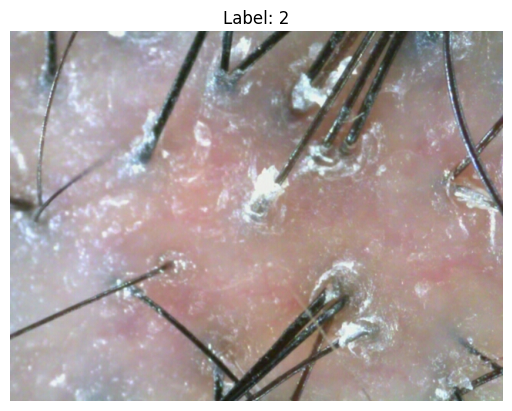

In [4]:
# Dataset check
dataset = HairLossDataset(image_dir, json_dir)

# 데이터셋 길이 확인
print(f"Dataset length: {len(dataset)}")

# 데이터셋에서 첫 번째 샘플 확인
if len(dataset) > 0:
    image, label = dataset[0]
    print(f"Label: {label}")
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()
else:
    print("Dataset is empty!")

In [5]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Dataset and DataLoader
dataset = HairLossDataset(image_dir, json_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

# 데이터셋 길이
total_length = len(dataset)
train_length = int(total_length * 0.8)  # 80% training
val_length = total_length - train_length  # 20% validation

# 8:2 비율로 데이터셋 분할
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

# DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0,  pin_memory=True)

# 데이터 확인
print(f"Total dataset size: {total_length}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")



Total dataset size: 18513
Train dataset size: 14810
Validation dataset size: 3703


In [7]:
# 클래스 수
classes = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

# Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, classes)  
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda


c:\Users\Daehwan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daehwan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

    for i, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())
    
    train_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}")

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
        for i, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("Training complete.")

Epoch 1/10 (Train): 100%|██████████| 232/232 [01:32<00:00,  2.50it/s, loss=1.03] 


Epoch [1/10] Train Loss: 1.0050


Epoch 1/10 (Val): 100%|██████████| 58/58 [00:22<00:00,  2.53it/s]


Epoch [1/10] Val Loss: 1.1096, Val Accuracy: 56.01%


Epoch 2/10 (Train): 100%|██████████| 232/232 [01:30<00:00,  2.57it/s, loss=1.02] 


Epoch [2/10] Train Loss: 0.9282


Epoch 2/10 (Val): 100%|██████████| 58/58 [00:22<00:00,  2.56it/s]


Epoch [2/10] Val Loss: 0.9605, Val Accuracy: 60.36%


Epoch 3/10 (Train): 100%|██████████| 232/232 [01:29<00:00,  2.58it/s, loss=0.762]


Epoch [3/10] Train Loss: 0.8987


Epoch 3/10 (Val): 100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Epoch [3/10] Val Loss: 0.9010, Val Accuracy: 62.98%


Epoch 4/10 (Train):  46%|████▌     | 106/232 [00:41<00:49,  2.54it/s, loss=0.982]


KeyboardInterrupt: 